<h1 style="font-size:300%">X-ray wrist classifier</h1>

This notebook is a fun assignment that uses [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained model for image classification to classify images of x-rays of the wrist. In this classifier we are going to look at x-rays that do or don't have a cast and are broken or not. We use a subset of the [Wrist X-ray dataset](https://ruiyangju.github.io/GRAZPEDWRI-DX_JU/) by Rui-Yany Ju. 

![X-ray robot.png](<attachment:X-ray robot.png>)
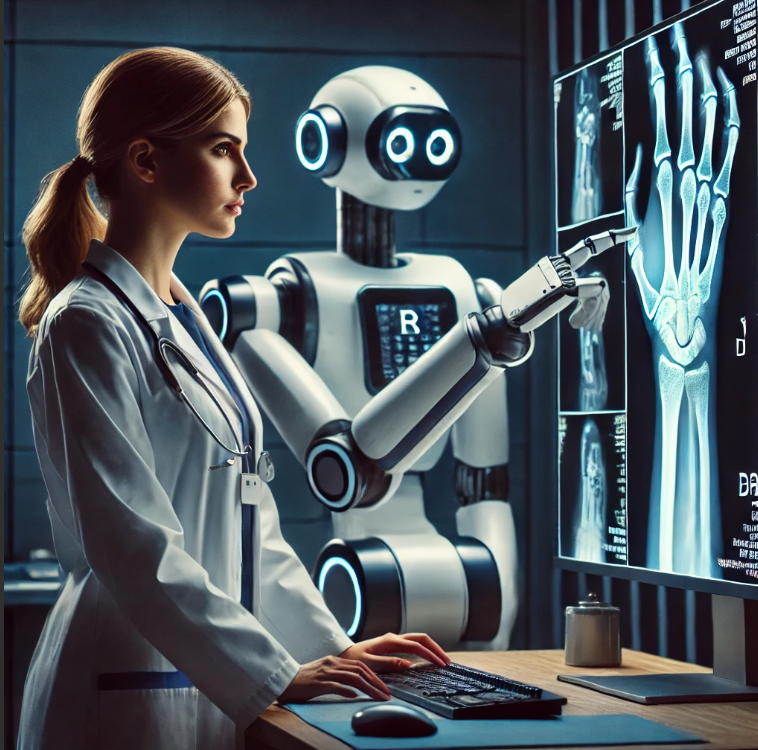

# Loading and setting the data path
This notebook uses torchvision & pytorch lightning. We do have to load these in. Besides that set the path where the classifier can find the data.

In [22]:
import os, pandas, platform, torch, torchvision, pytorch_lightning

torch.manual_seed(42)

data_path = "D:\\Minor\\Classification\\Pols x-ray\\Data 8bit"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| pytorch_lightning", pytorch_lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.13.2 | torch 2.6.0+cpu | torchvision 0.21.0+cpu | pytorch_lightning 2.5.0.post0 | pandas 2.2.3


# Checking
To make sure the classifier can find the data we are going to let it show one of the images to see if we can visualize it.

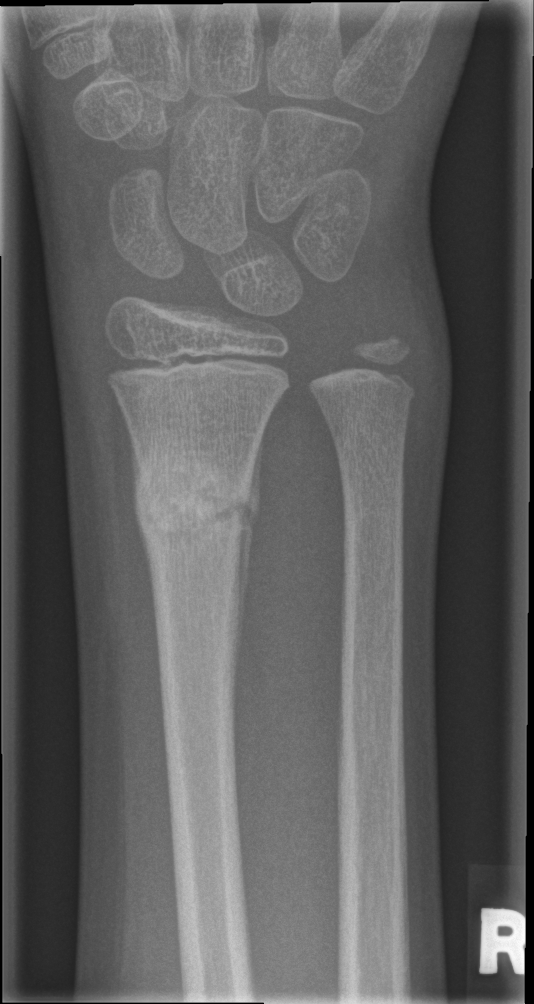

In [23]:
import PIL

img=PIL.Image.open('D:\\Minor\\Classification\\Pols x-ray\\Data 8bit\\AP #\\AP# (1).png')
img

# Loading the model
For this classifier I am using the ResNet50 model. This model gave me more accuracy then the ResNet18.

In [24]:
from torchvision import models

pretrained_model = models.resnet50(weights="DEFAULT")

# Transform
With the next bit of code we are going to transform the images to 244 by 244. By doing this all the images are going to be the same size.

In [25]:
from torchvision import transforms

image_size = (244, 244)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

# Preprocessing

In this part of the code we are going to use data augmentation. This is going to change some of the images that we already have to make more data that we can train with without more actual data. 
It is also going to split the augmented data into train and test.

In [26]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_path = "D:\\Minor\\Classification\\Pols x-ray\\Data 8bit"

full_dataset_train = ImageFolder(root=data_path, transform=train_transform)
full_dataset_val = ImageFolder(root=data_path, transform=val_transform)

train_size = int(0.8 * len(full_dataset_train))
val_size = len(full_dataset_train) - train_size

train_dataset, _ = random_split(full_dataset_train, [train_size, val_size])
_, val_dataset = random_split(full_dataset_val, [train_size, val_size])

classes = full_dataset_train.classes


# Augmentation visualization
We are going to make the augmentation visual by using matplotlib. This way we can see what the code is doing to the images and check if it works.

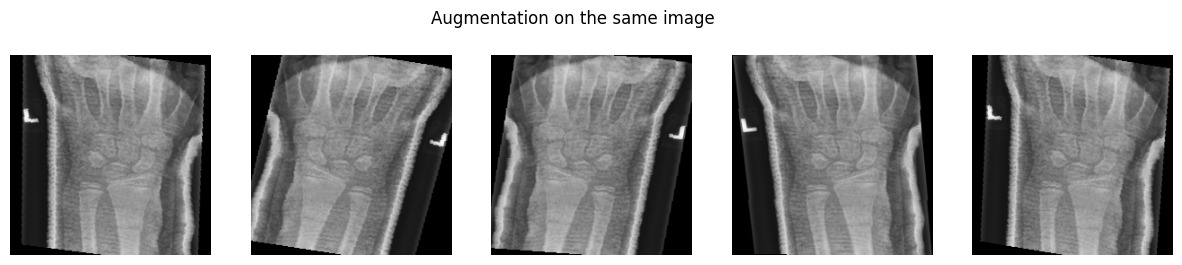

In [27]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]  

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img_aug, _ = train_dataset[0]  
    axs[i].imshow(img_aug.permute(1, 2, 0), cmap='gray')
    axs[i].axis('off')
plt.suptitle("Augmentation on the same image")
plt.show()

# Create a data module
Here we extend the LightningDataModule to create a DataModule that splits the dataset into Train, Validate and Test data. It is also going to print the classes as a check to see if he got the folders right.

In [28]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

class ImageFolderDataSet(LightningDataModule):
    def __init__(self, path, transform, split=[.7, .2, .1], batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.path = path
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.data = ImageFolder(self.path, transform=self.transform)
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def classes(self):
        return self.data.classes



dataset = ImageFolderDataSet(data_path, transform)
dataset.setup()
classes = dataset.classes()
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['AP #', 'AP non #', 'Cast # AP', 'Cast # L', 'Cast non AP', 'Cast non L', 'L #', 'L non #']


# Image classifier model
A LightningModule is extended to load the pretrained model that we downloaded before, and allow it to be fine-tuned. We include the common metrics Accuracy, Precision and Recall. It is possible to tine-tune all the layers in the model or keep all layers except the final decision frozen.
Besides that it is also going to set the paremeters of when the model should stop with training.

In [29]:
from pytorch_lightning import LightningModule
from torch import nn
import torch
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall

class ImageClassifierModel(LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()  
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True) 

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])            

model = ImageClassifierModel(pretrained_model, num_classes=len(classes))


# Training
When starting this cell the model is going to start training.
The model is going to stop training when the epoch has reached a 1.0 for accuracy and hasn't inproved for 10 epochs.
I did set a max of 100 epochs to make sure it does stop if it doesn't reach the accuracy.

In [30]:
from pytorch_lightning.loggers import CSVLogger 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

logger = CSVLogger(save_dir=".")

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    mode="max", 
    stopping_threshold= 1.0
)

trainer = Trainer(max_epochs=100, logger=logger, callbacks=[early_stopping])
trainer.fit(model, datamodule=dataset)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 23.5 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
16.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.098    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


c:\Users\femke\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 10/10 [00:39<00:00,  0.26it/s, v_num=26, val_loss=1.110, val_accuracy=0.456]


# Making the training visual
With the use of metric plot we are going to visualize the epochs the model made and we can look at the accuracy.

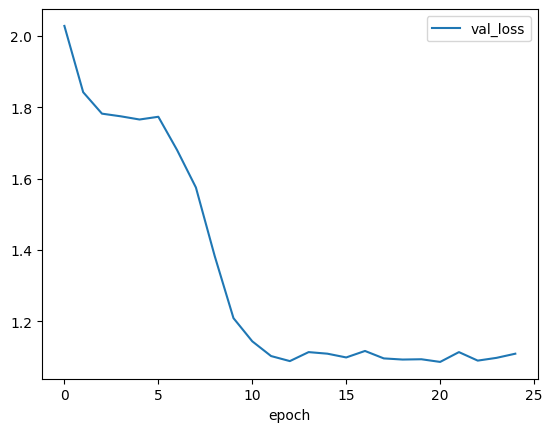

In [31]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

# Test the model
Now we are going to test the model by using it with the test data that has been set aside sinds the beginning.
When it is done we are going to get a table in wich we can see the: Accuracy, precision and recall.

In [32]:
scores = trainer.test(model, datamodule=dataset, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(len(classes))]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(len(classes))]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(len(classes))]
df = pandas.DataFrame({"class": classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

Testing DataLoader 0: 100%|██████████| 2/2 [00:04<00:00,  0.47it/s]


,accuracy,precision,recall
class,,,
AP #,0.6,1.000000,0.6
AP non #,1.0,0.777778,1.0
Cast # AP,1.0,0.857143,1.0
Cast # L,0.5,1.000000,0.5
Cast non AP,0.8,0.800000,0.8
Cast non L,1.0,0.500000,1.0
L #,1.0,1.000000,1.0
L non #,1.0,1.000000,1.0


# Inference
Inference = "putting a machine learning model into production."
With this part of the code we are going to run the model and get a visual output in the form of a plot.
In the plot we are going to see the top 3 predictions that the model gave to an image and the actual label of the image.
If the text is in black that means that the prediction was good. If it's in red that means it was wrong.

In [33]:
inference_dataloader = dataset.test_dataloader()
preds = trainer.predict(model, dataloaders=inference_dataloader)
predictions = torch.cat(preds)
images = torch.cat([x for x, y in inference_dataloader])
labels = torch.cat([y for x, y in inference_dataloader])

Predicting DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  0.55it/s]


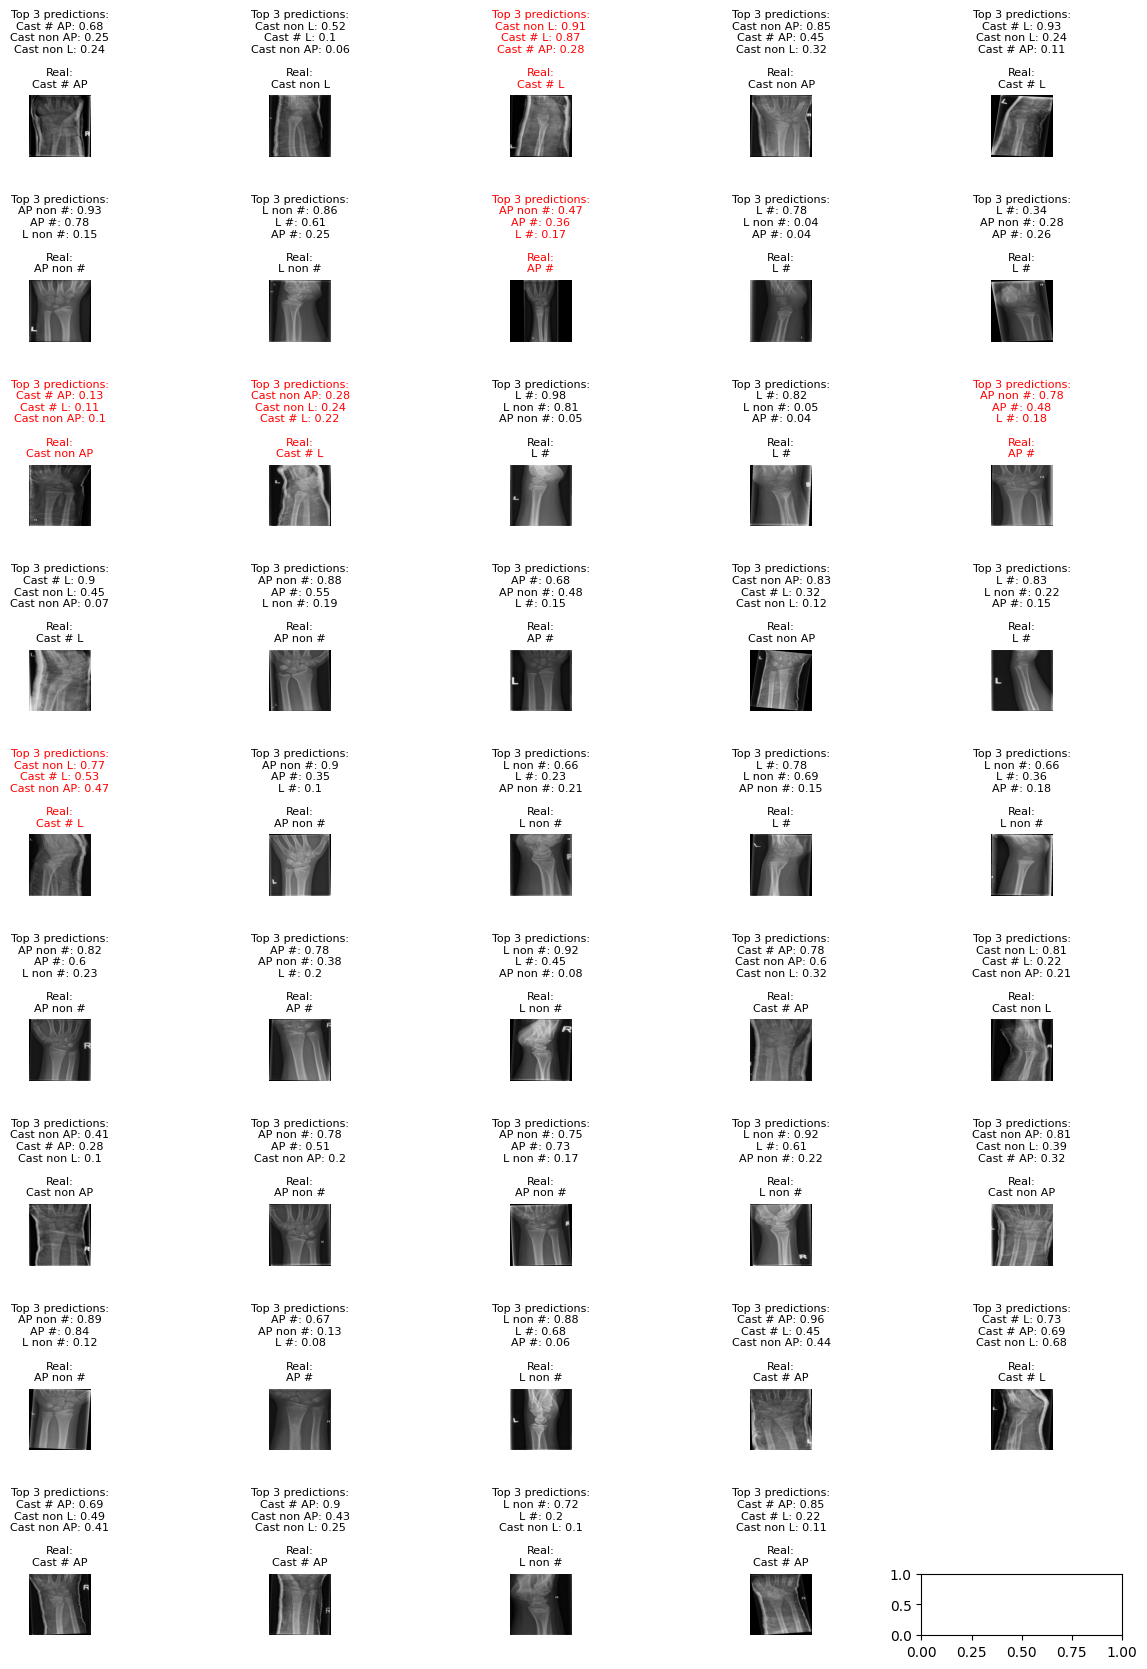

In [34]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 5, figsize=(15, 20))
axs = axs.flatten()

for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = torch.sigmoid(prediction)  

    top3_indices = torch.argsort(probabilities, descending=True)[:3]
    top3_probs = [round(probabilities[idx].item(), 2) for idx in top3_indices]
    top3_labels = [classes[idx] for idx in top3_indices]

    pred_text = "\n".join([f"{label}: {prob}" for label, prob in zip(top3_labels, top3_probs)])

    if truth.dim() == 0:  
        truth_text = classes[truth.item()]  
    else:
        truth_text = "\n".join([classes[idx] for idx in range(len(classes)) if truth[idx] > 0])  

    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(f"Top 3 predictions:\n{pred_text}\n\nReal:\n{truth_text}", 
                     color="red" if classes[torch.argmax(probabilities)] != truth_text else "black",
                     fontsize=8) 
    axs[i].axis("off")  

plt.subplots_adjust(hspace=2)  
plt.show()


# Making a confusion matrix
To see if the mistakes the model makes are with a reason we are going to make a confusion matrix. With this matrix we can visualize the label giving by the classifier.

Predicting DataLoader 0: 100%|██████████| 2/2 [00:05<00:00,  0.39it/s]


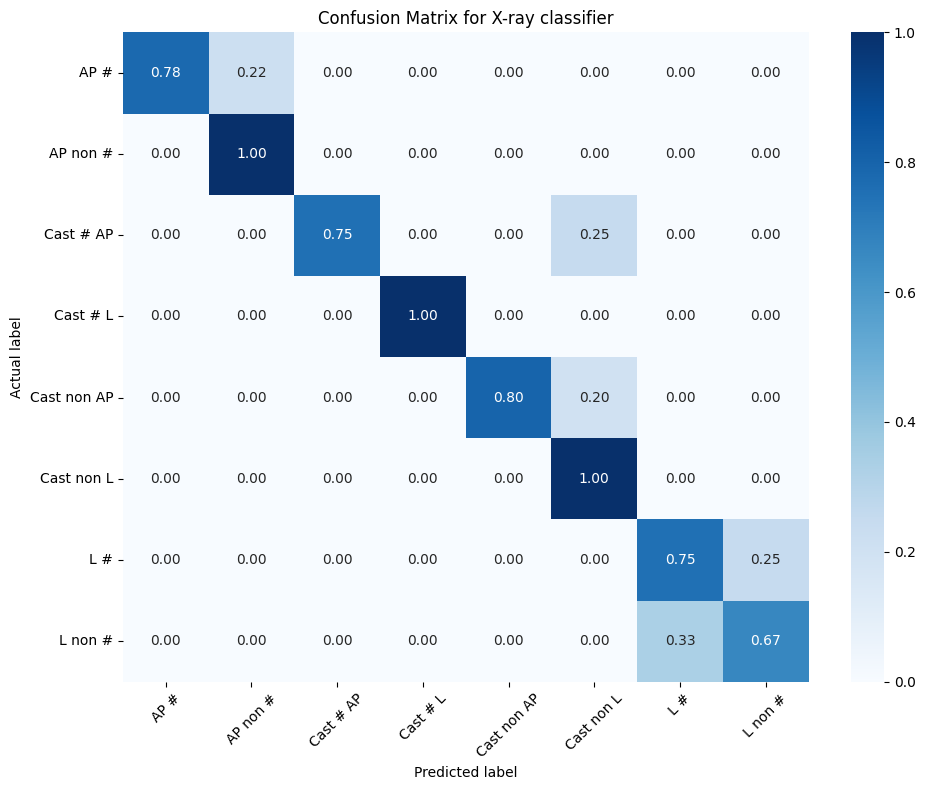

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

label_names = ['AP #', 'AP non #', 'Cast # AP', 'Cast # L', 'Cast non AP', 'Cast non L', 'L #', 'L non #']

inference_dataloader = dataset.test_dataloader()

preds = trainer.predict(model, dataloaders=inference_dataloader)

predictions_raw = torch.cat(preds)

if predictions_raw.ndim == 2 and predictions_raw.shape[1] > 1:
    predictions = torch.argmax(predictions_raw, dim=1)
else:
    predictions = predictions_raw

labels = torch.cat([y for x, y in inference_dataloader])

cm = confusion_matrix(labels.numpy(), predictions.numpy())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for X-ray classifier')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Looking at the confusion matrix above the mistakes the classifier makes are not without reason. We can see that the classifier has the most difficulty with the fractures. It is really good at defining if the image has a cast or not and the difference in angles it also has down. For now this is the best I can train this model but there could be looked at different ResNet models or adding classes to make it even more accurate.